#IMPORT ALL LIBRARIES

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa import stattools
%matplotlib inline
plt.rcParams['figure.figsize'] = (15, 6)
import numpy
from math import sqrt

# OBTAIN DATA THROUGH SCRAPING

In [ ]:
import requests
import csv
import os
from bs4 import BeautifulSoup
from datetime import datetime, timedelta

def get_load_data(date):
    url = 'http://www.delhisldc.org/Loaddata.aspx?mode='
    print('Scraping', date)
    resp = requests.get(url+date) # send a get request to the url, get response
    soup = BeautifulSoup(resp.text, 'lxml') # Yummy HTML soup
    table = soup.find('table', {'id':'ContentPlaceHolder3_DGGridAv'}) # get the table from html
    trs = table.findAll('tr') # extract all rows of the table
    if len(trs[1:])!=0: # no need to create csv file, if there's no data, for Aug month of 2017
        csv_filename = 'monthdata.csv'
        with open(csv_filename, 'a') as f:
            writer = csv.writer(f)
            count=0
            for tr in trs[1:]:
                time, delhi = tr.findChildren('font')[:2]
                writer.writerow([date+' '+time.text, delhi.text])
                count+=1
    if count != 288:
        print(count)
        print('Some of the load values are missing..')
    else:
        print('Done')

SAVE DATA LOADED INTO CSV

In [ ]:
for i in range(10, 0, -1):
    yesterday = datetime.today() - timedelta(i)
    yesterday = yesterday.strftime('%d/%m/%Y')
    print(yesterday)
    get_load_data(yesterday)    

14/04/2023
Scraping 14/04/2023
286
Some of the load values are missing..
15/04/2023
Scraping 15/04/2023
287
Some of the load values are missing..
16/04/2023
Scraping 16/04/2023
287
Some of the load values are missing..
17/04/2023
Scraping 17/04/2023
287
Some of the load values are missing..
18/04/2023
Scraping 18/04/2023
287
Some of the load values are missing..
19/04/2023
Scraping 19/04/2023
287
Some of the load values are missing..
20/04/2023
Scraping 20/04/2023
286
Some of the load values are missing..
21/04/2023
Scraping 21/04/2023
286
Some of the load values are missing..
22/04/2023
Scraping 22/04/2023
Done
23/04/2023
Scraping 23/04/2023
Done


In [ ]:
!head monthdata.csv

14/04/2023 00:00,3549.960
14/04/2023 00:05,3505.220
14/04/2023 00:10,3472.790
14/04/2023 00:15,3476.800
14/04/2023 00:20,3447.980
14/04/2023 00:25,3438.000
14/04/2023 00:30,3411.680
14/04/2023 00:35,3370.660
14/04/2023 00:40,3369.780
14/04/2023 00:45,3355.520


In [ ]:
import pandas as pd

READ DATA FROM CSV

In [ ]:
data = pd.read_csv('monthdata.csv', skiprows=[0], header=None, names=['datetime', 'load'], index_col=[0], parse_dates=[0], infer_datetime_format=True)

In [ ]:
data.head()

,load
datetime,
2023-04-14 00:05:00,3505.22
2023-04-14 00:10:00,3472.79
2023-04-14 00:15:00,3476.80
2023-04-14 00:20:00,3447.98
2023-04-14 00:25:00,3438.00


In [ ]:
data.shape

(17705, 1)

#PLOT OF LOAD CURVE ON A RANDOM DAY

<ipython-input-15-a2653c59e135>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  data['26/03/2023'].plot()
<ipython-input-15-a2653c59e135>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  data['26/03/2023'].plot()


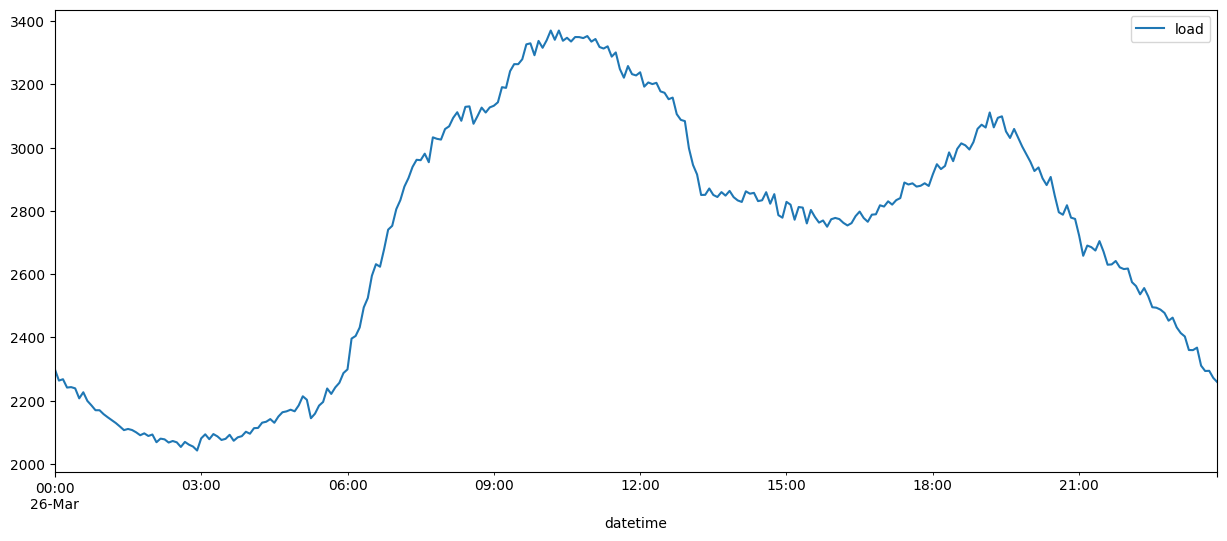

In [ ]:
data['26/03/2023'].plot()
plt.rcParams['figure.figsize'] = (15, 6)
plt.show()

DTEREMINATION OF SEASONAL TRENDS IN TIME SERIES DATA OF LOAD

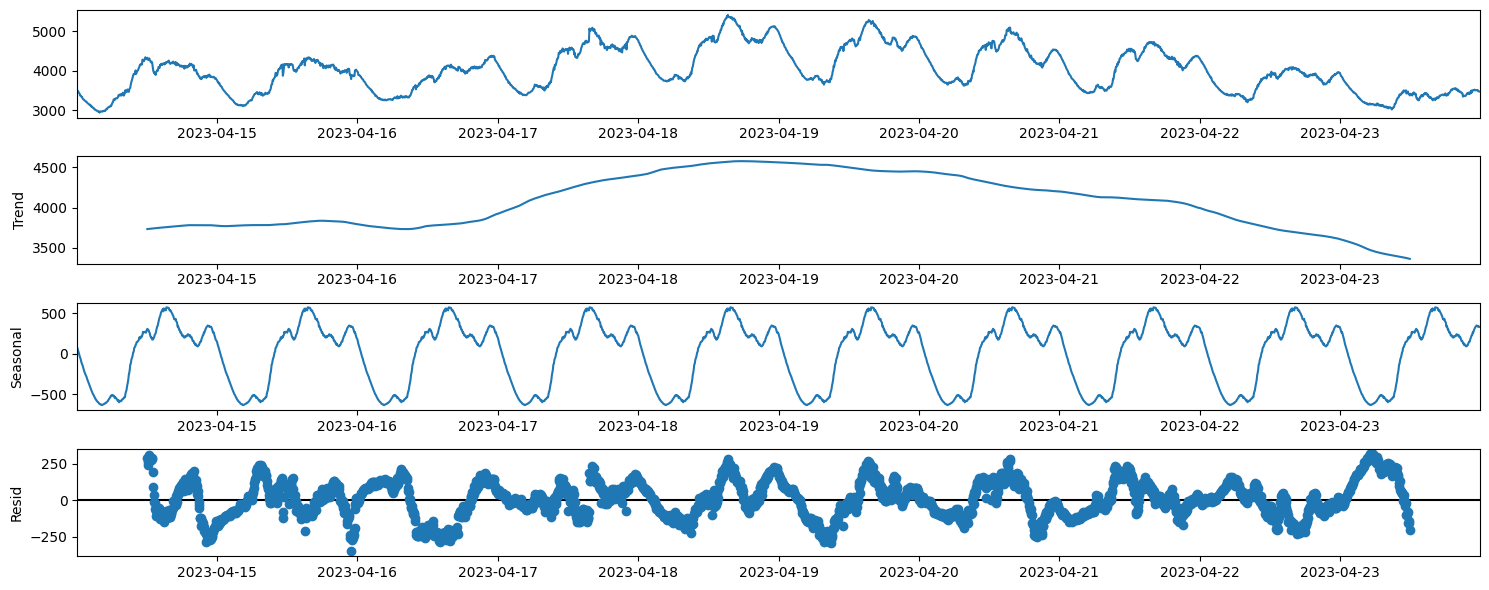

In [ ]:
plt.rcParams['figure.figsize'] = (15, 6)
decompfreq = 288 #daily freq
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(data['03/2023':], period=decompfreq, model='aditive')
result.plot()
plt.show()

In [ ]:
!pip install pmdarima

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


GRID SEARCH OF PARAMATERS(P,D,Q) OF SARIMA 

In [ ]:
from pmdarima.arima import auto_arima
stepwise_model = auto_arima(data, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,1,1)[12]             : AIC=inf, Time=27.88 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=91179.916, Time=0.92 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=89175.353, Time=5.26 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=inf, Time=18.11 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=90906.009, Time=1.09 sec
 ARIMA(1,1,0)(2,1,0)[12]             : AIC=88389.313, Time=12.32 sec
 ARIMA(1,1,0)(2,1,1)[12]             : AIC=inf, Time=33.02 sec


KeyboardInterrupt: ignored

FITTING SARIMA MODEL ON LOAD DATA

In [ ]:
%%time
mod = sm.tsa.statespace.SARIMAX(data,
                                order=(0,1,1),
                                seasonal_order=(0,2,2,24),
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()
print(results.summary().tables[1])
'''For fitting on 30days of hourly data this takes , and 6500% CPU'''

/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.9/dist-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0600      0.015     -3.904      0.000      -0.090      -0.030
ma.S.L24      -1.9984      5.221     -0.383      0.702     -12.232       8.235
ma.S.L48       0.9999      5.225      0.191      0.848      -9.241      11.241
sigma2      1160.2256   6058.635      0.191      0.848   -1.07e+04     1.3e+04
CPU times: user 5min 45s, sys: 2min 2s, total: 7min 48s
Wall time: 4min 36s


'For fitting on 30days of hourly data this takes , and 6500% CPU'

In [ ]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                        SARIMAX Results                                        
===============================================================================================
Dep. Variable:                                    load   No. Observations:                 2868
Model:             SARIMAX(0, 1, 1)x(0, 2, [1, 2], 24)   Log Likelihood              -13837.634
Date:                                 Mon, 24 Apr 2023   AIC                          27683.269
Time:                                         17:22:25   BIC                          27706.974
Sample:                                              0   HQIC                         27691.830
                                                - 2868                                         
Covariance Type:                                   opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0600      0.015     -3.904      0.000      -0.090      -0.030
ma.S.L24      -1.9984      5.221     -0.383      0.702     -12.232       8.235
ma.S.L48       0.9999      5.225      0.191      0.848      -9.241      11.241
sigma2      1160.2256   6058.635      0.191      0.848   -1.07e+04     1.3e+04
===================================================================================
Ljung-Box (L1) (Q):                   0.57   Jarque-Bera (JB):              2881.31
Prob(Q):                              0.45   Prob(JB):                         0.00
Heteroskedasticity (H):               0.69   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         7.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [ ]:
from statsmodels.tsa.arima_model import ARIMAResults

In [ ]:
import statsmodels
statsmodels.__version__ 


'0.13.5'

In [ ]:
results.save('model1.pkl')

In [ ]:
loaded = statsmodels.tsa.arima.model.ARIMAResults.load('model1.pkl')

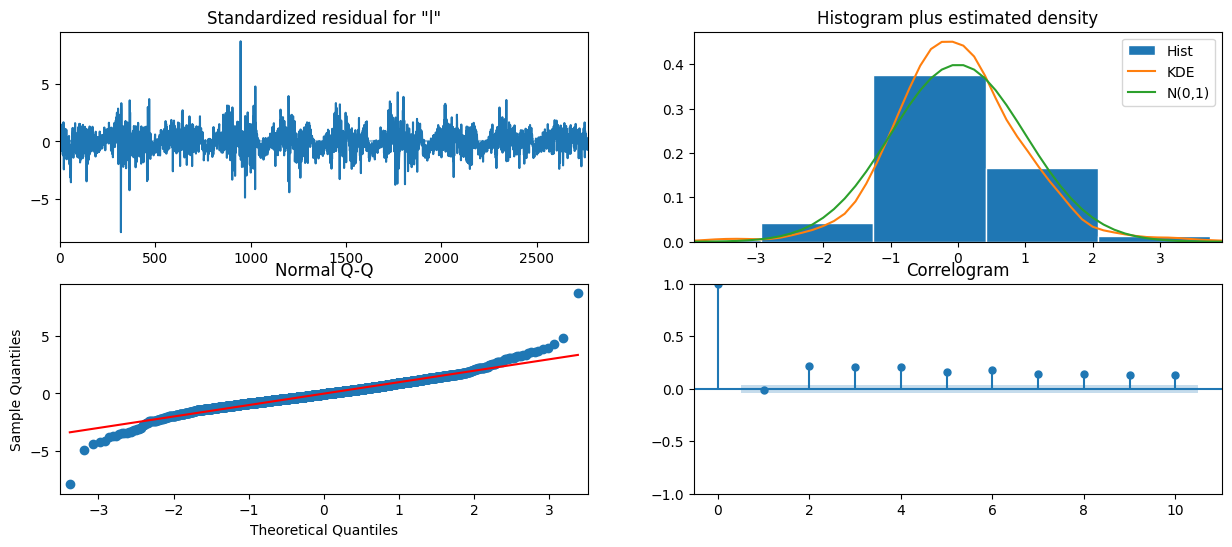

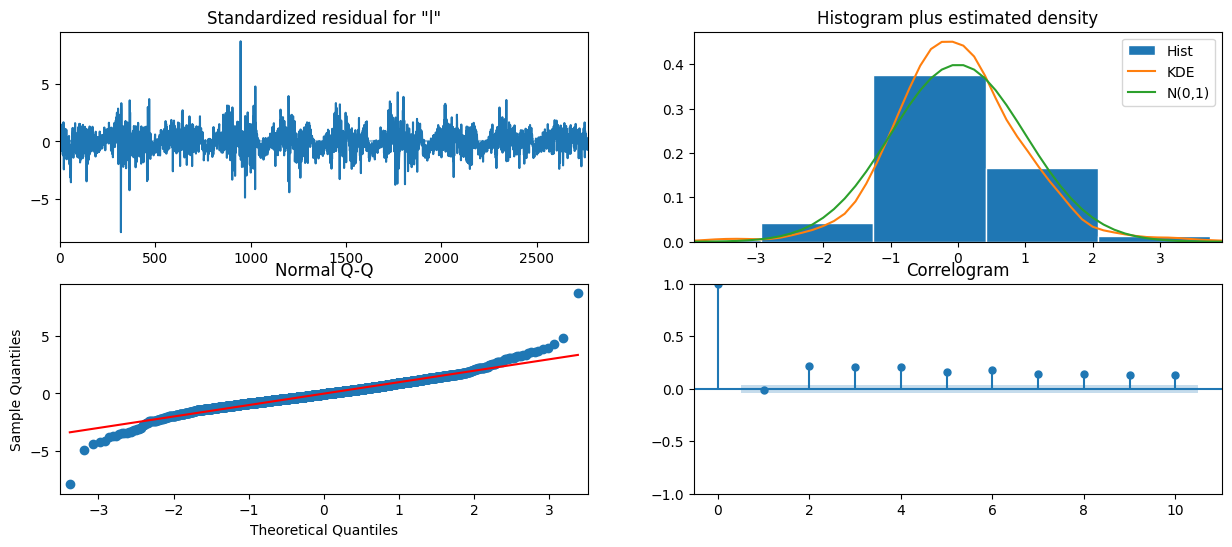

In [ ]:
# loaded.plot_diagnostics()
results.plot_diagnostics()

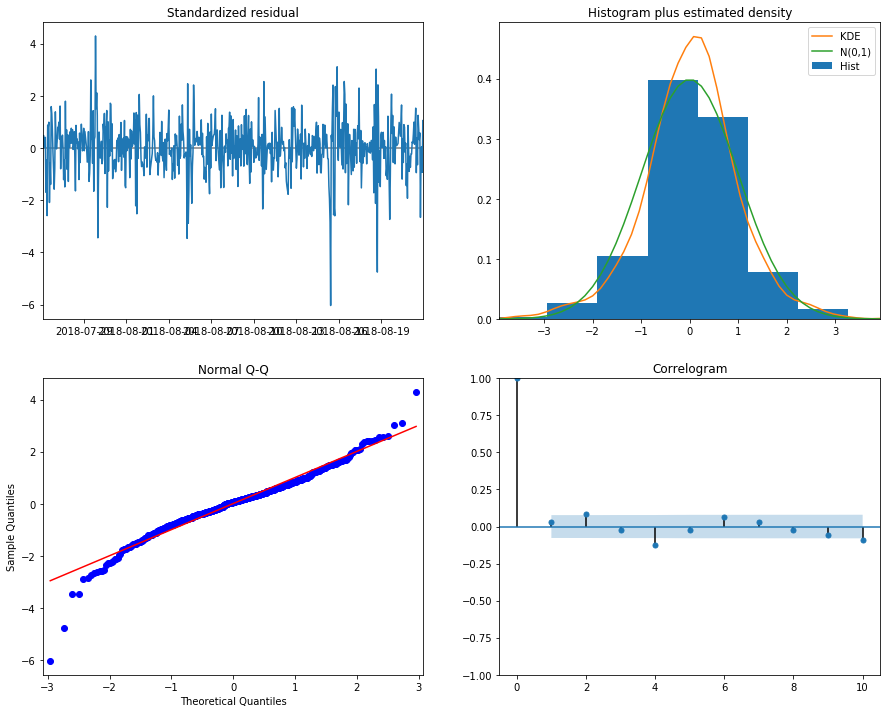

In [ ]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

#GET PREDICTIONS OF DATA FROM SARIMA MODEL ON A PARTICULAR DAY

In [ ]:
pred = results.get_prediction(start=pd.to_datetime('2023-02-23 00:05:00'), end=pd.to_datetime('23-03-23 23:45:00'), dynamic=False)
pred_ci = pred.conf_int()

KeyError: ignored

In [ ]:
pred.predicted_mean.shape

(2868,)

<ipython-input-73-e9ded2e616bd>:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  plt.plot(range(24), data['23/02/2023'])
<ipython-input-73-e9ded2e616bd>:1: FutureWarning: Indexing a DataFrame with a datetimelike index using a single string to slice the rows, like `frame[string]`, is deprecated and will be removed in a future version. Use `frame.loc[string]` instead.
  plt.plot(range(24), data['23/02/2023'])


ValueError: ignored

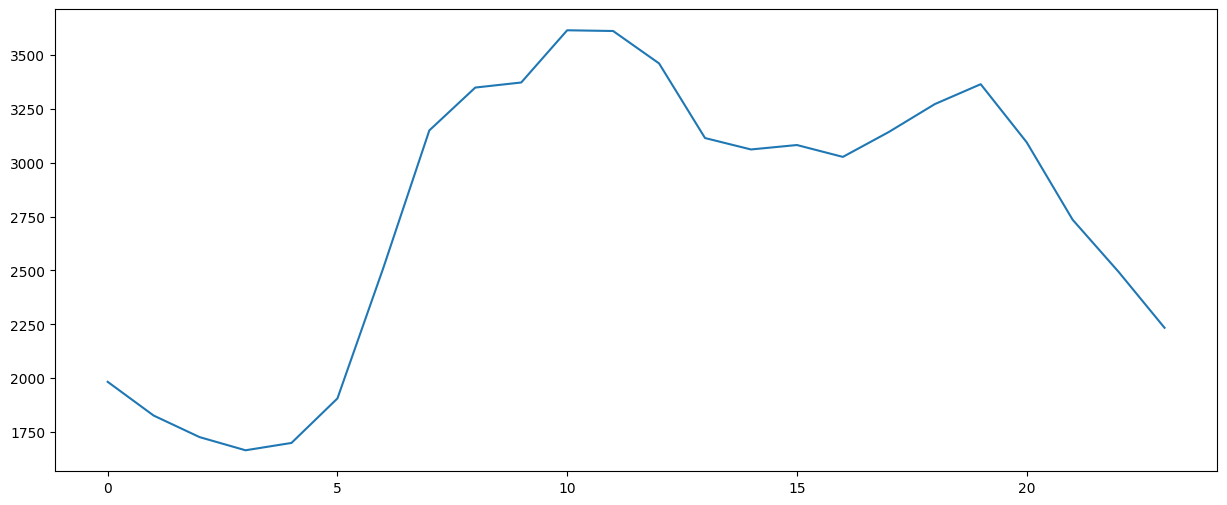

In [ ]:
plt.plot(range(24), data['23/02/2023'])
plt.plot(range(24), pred.predicted_mean)#.plot(figsize=(15,6))
plt.show()

In [ ]:
pred.predicted_mean.to_csv('arima_pred.csv', index_label='datetime', header=['load'])